<br>
<h1 style="font-family:sans-serif; text-align:center"> 
<!--     <span style='color: pink'> Twitter analysis of </span> -->
    <span style='color: white; font-size:50%; text-shadow: 0px 0px 15px black'> Twitter analysis of </span>
<!--     <span style='color:#00acee'> Twitter analysis of </span> -->
<!--     <span style="-webkit-text-stroke"> Twitter analysis of</span> -->
<!--     <span class="hr3" style='color:#e40843; letter-spacing: 4px; font-size:105%'> Canada</span> -->
    <span class="hr3" style='color:#e40843; font-size:60%; text-shadow: 0px 0px 30px pink'>Canada </span> <span class="hr3" style='color:gray; font-size:50%; text-shadow: 0px 0px 30px pink'>response to Covid-19</span><br>
</h1>

# Sentiment Analysis

The aim of this notebook is to analyze the retrieved tweets obtained using *snscrape*, from March 1st to April 30th of 2020, from Government of Canada official Twitter accounts.

_Authors: Leo Cuspinera ([cuspime](https://github.com/cuspime)) and Victor Cuspinera ([vcuspinera](https://github.com/vcuspinera))_

## Import libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime, timedelta, date

# To plot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()

# Preprocess libraries
import re
import spacy
import string
import en_core_web_sm
nlp = en_core_web_sm.load()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# WordCloud
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For Sentiment analysis
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from scipy.stats import ttest_ind

# Necessary to plot timeseries:
pd.plotting.register_matplotlib_converters()

## Open `json` file with all tweets

In [2]:
%%time

# Parameters
my_folder = "../tweets/"

# Open `json` files of tweets with SpaCy sentiment
df = pd.DataFrame()
for i in range(0,10):
    df_sub = pd.read_json(my_folder + 'tweets_sentiment_' + str(i) + '.json')
    df = pd.concat([df, df_sub])

df.reset_index(drop=True, inplace=True)

CPU times: user 48.9 s, sys: 5.22 s, total: 54.1 s
Wall time: 54.2 s


In [3]:
# show the data frame
df.tail(3)

account                date  replyCount  retweetCount  \
2915142  JustinTrudeau 2020-04-30 00:00:27           1             0   
2915143  JustinTrudeau 2020-04-30 00:00:19           1             0   
2915144  JustinTrudeau 2020-04-30 00:00:08           0             0   

         likeCount  quoteCount lang         sourceLabel      username  \
2915142          2           0   en  Twitter for iPhone  SRodrigues52   
2915143          0           0   en  Twitter for iPhone       pffoote   
2915144          0           0   en     Twitter Web App  DavidCBarron   

         followersCount  friendsCount                location  \
2915142             219           412              London, On   
2915143             356          1531  St. John's, NL, Canada   
2915144             231           331        Brampton Ontario   

                                                     tweet         day  \
2915142         @shelbzzzzy @justintrudeau quit your job 🧐  2020-04-30   
2915143  @rcaf_arc @cfsnowbirds @canadianforces @cfoper...  2020-04-30   
2915144  @cbcnews @ctvnews @justintrudeau @celliottabil...  2020-04-30   

         announcement  polarity  subjectivity  
2915142          True  0.000000      0.000000  
2915143          True  0.392857      0.517857  
2915144          True -1.000000      1.000000

In [4]:
# Save the final version of the tweet's database
df.to_json(my_folder + 'tweets_db_sentiment.json')

## Analysis of all tweets
In this section we work with wordcloud and sentiment analysis of all tweets.

### Wordcloud

In [5]:
stopwords = set(STOPWORDS)
stopwords.update(['lo','u',"I'm","We'll", 'Nous', 'di', 'Herr', 'ist','de','die',
                  'a','por','https','I', 'noch', 'much', 'uns', 'many', 'day', 'come',
                  'los', 'eine', 'wie', 'aut', 'les', 'sind','un', 'et','il','le','las',
                  'la', 'nos','will', 'dan', 'se', 'au', 'una', 'unas','le','aut','and',
                  'den', 'ein', 'al', 'des','_','il', 'e', 'en', 'que',
                  'non', 'da', 'Ich', 'la', 'mit', 'zu', 'es', 'con', 'von', 'und', 'auf', 
                  'auch','sich', 'der', 'hasta', 'das', 'Sie', 'para', 'el', 'per'])

def CleanText(txt):
    txt = re.sub(r'https?:\/\/.*[\r\n]*','',txt) # Remove hyperlinks
    # Remove some nonsense
    txt = re.sub(r'dans le','',txt)
    txt = re.sub(r'Sie uns','',txt)
    txt = re.sub(r'RT[\s]+','',txt) # remove retweets
    txt = re.sub(r'\d+','',txt) #remove digits
    txt = re.sub(' '+' | '.join(stopwords).lstrip(' | ')+' ',' ',txt ) 
    # 🔥 This is the right way to remove stopwords
    return txt

In [6]:
# data and mask
allwords = ' '.join(df.tweet.values.tolist())
mask = np.array(Image.open('../img/Canadian_Flag.jpg'))

In [7]:
# get wordcloud
wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA',mask=mask, #stopwords=stopwords#,
                  ).generate(allwords)

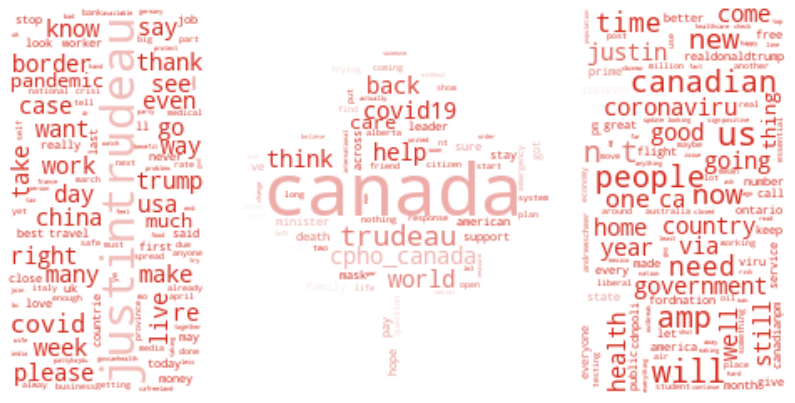

In [8]:
# plot
plt.figure(figsize=(14,8))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../img/canada_word_cloud.jpg", format="jpg")

> In the wordcloud we find that the most used word in the tweets is `canada`, followed by `justintrudeau`. There are other words highly used in tweets as `us`,`time`, `canadian`, `people`, `will`, `coronavirus`, ` covid`, `right`, `china`, among others.

### Repetition of words

In [9]:
df_weights = pd.DataFrame.from_dict(wcloud.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'weight'})

In [10]:
pd.DataFrame(wcloud.layout_)[1]
df_weights.head()

word    weight
0         canada  1.000000
1  justintrudeau  0.279725
2             us  0.122011
3           will  0.114868
4            n't  0.101240

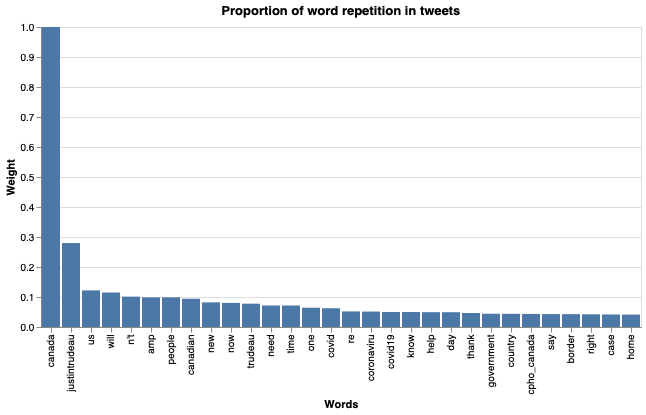

In [11]:
# plot
alt.Chart(df_weights[:30]).mark_bar().encode(
    x=alt.X('word', sort=df_weights.word.to_list(), title="Words"),
    y=alt.Y('weight', title="Weight")
).properties(
    title="Proportion of word repetition in tweets"
)

> In the previous plot we identify the words with higher proportion of repetitions, considering `canada` as the word more repeated in tweets. These more repeated words coincide with the biggest words in the previous word cloud.

## Analysis comparing tweets before and after Trudeau's announcement
In this section we work with wordcloud and sentiment analysis comparing results of tweets published before Trudeau's announcement, with tweets published after the announcement.

### Wordclouds

In [12]:
allwords_before = ' '.join(df[df.announcement == False].tweet.values.tolist())
allwords_after = ' '.join(df[df.announcement == True].tweet.values.tolist())

In [21]:
# get wordcloud
wcloud_before = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA', mask=mask).generate(allwords_before)
wcloud_after = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA', mask=mask).generate(allwords_after)

Text(0.5, 1.0, "Wordcloud of tweets before Trudeau's announcement\n")

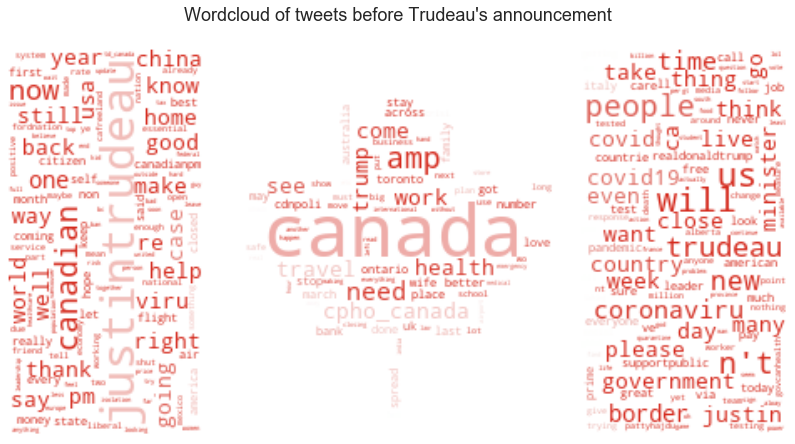

In [34]:
# Wordcloud - before Trudeau's announcement
plt.figure(figsize=(14,8))
plt.imshow(wcloud_before.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of tweets before Trudeau's announcement\n", fontsize=18)

Text(0.5, 1.0, "Wordcloud of tweets after Trudeau's announcement\n")

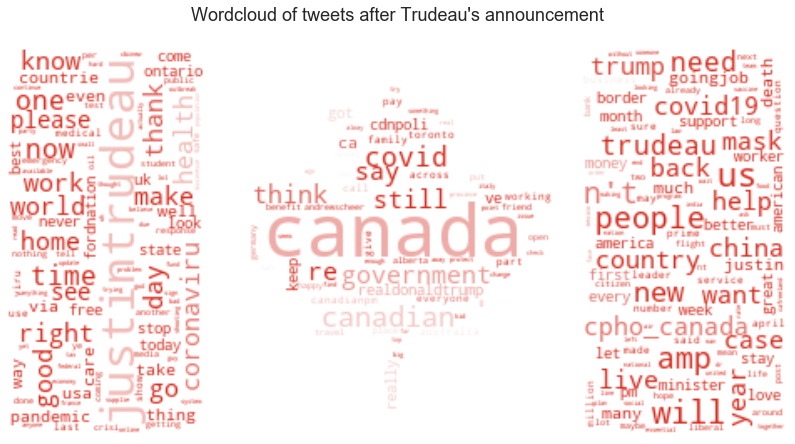

In [35]:
# Wordcloud - after Trudeau's announcement
plt.figure(figsize=(14,8))
plt.imshow(wcloud_after.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of tweets after Trudeau's announcement\n", fontsize=18)

> When comparing the wordcloud of tweets published before Trudeau's announcement on March 27th 2020, with the wordcloud of tweets published after the announcement, it looks that the words more used are the same in both graphs.

### Repetition of tweets before and after Trudeau's announcement

In [16]:
df_w_before = pd.DataFrame.from_dict(wcloud_before.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'w_before'})
df_w_after = pd.DataFrame.from_dict(wcloud_after.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'w_after'})

In [17]:
df_w = pd.merge(df_w_before, df_w_after, on="word")
df_w.head()

word  w_before   w_after
0         canada  1.000000  1.000000
1  justintrudeau  0.295393  0.267799
2             us  0.124762  0.119918
3           will  0.121176  0.110068
4         people  0.102313  0.096318

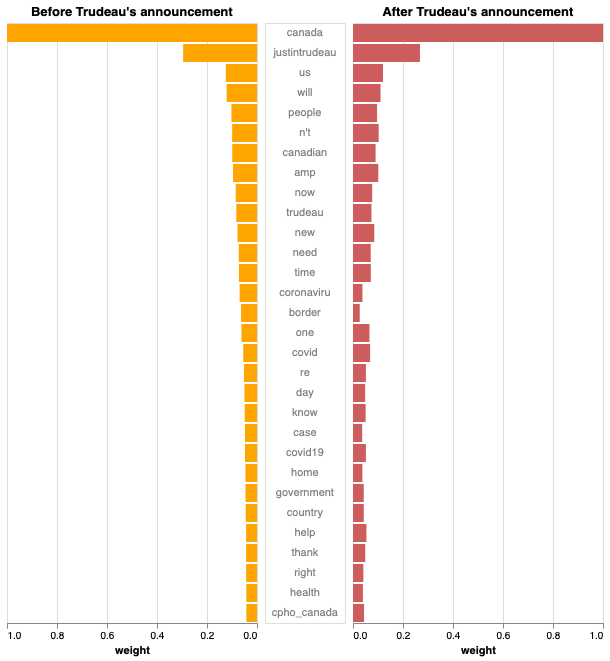

In [18]:
#plot
base = alt.Chart(df_w[:30]).properties(width=250)
my_order = df_w.word.to_list()

left = base.encode(
    y=alt.Y('word', axis=None, sort=my_order),
    x=alt.X('w_before', title='weight',
    scale=alt.Scale(reverse=True)),
    tooltip=['word', 'w_before']
).mark_bar(color='orange').properties(title="Before Trudeau's announcement")

middle = base.encode(
    y=alt.Y('word', axis=None, sort=my_order),
    text=alt.Text('word'),
).mark_text(color='grey').properties(width=80)

right = base.encode(
    y=alt.Y('word:O', axis=None, sort=my_order),
    x=alt.X('w_after', title='weight'),
    tooltip=['word', 'w_after']
).mark_bar(color='indianred').properties(title="After Trudeau's announcement")

alt.concat(left, middle, right, spacing=5)

> In general, it looks that each word have similar weights in the tweets published before and after Trudeau's announcement. Among the 30 most-repeated words, `coronavirus` and `border` have higher weights before the annoucement; in contrast it looks that `covid` and `help` have higher weights after the annoucement.

### Sentiment anlysis by tweets - general
Exploring sentiment analysis with [SpaCy](https://spacy.io):  
- `polarity` score is a float within the range [-1.0, 1.0]
- `subjectivity` is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective

In [19]:
# change values of announcement
df.announcement = ["before" if i==False else "after" for i in df.announcement]

In [20]:
# polarity data
df['bin_polarity'] = pd.cut(df.polarity, bins=50)
df_bin_polarity = pd.DataFrame(df.groupby(['bin_polarity', 'announcement'])['tweet'].count()).reset_index()
df_bin_polarity.bin_polarity = [np.mean([i.left, i.right]) for i in df_bin_polarity.bin_polarity]

# subjectivity data
df['bin_subjectivity'] = pd.cut(df.subjectivity, bins=50)
df_bin_subjectivity = pd.DataFrame(df.groupby(['bin_subjectivity', 'announcement'])['tweet'].count()).reset_index()
df_bin_subjectivity.bin_subjectivity = [np.mean([i.left, i.right]) for i in df_bin_subjectivity.bin_subjectivity]

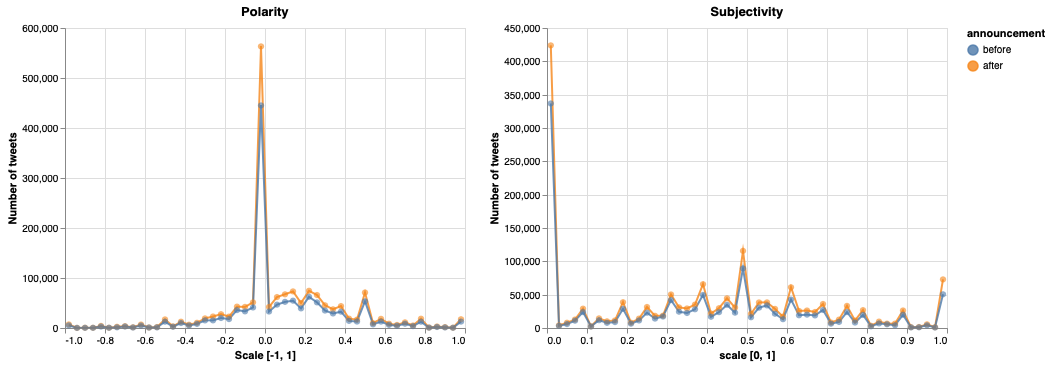

In [36]:
# polarity plot
polar = alt.Chart(df_bin_polarity).encode(
    alt.X("bin_polarity", title="Scale [-1, 1]" ,scale=alt.Scale(domain=(-1, 1))),
    alt.Y("tweet",  title="Number of tweets"),
    alt.Color('announcement', sort=['before', 'after'])
).properties(title="Polarity")

polar_line=polar.mark_line(clip=True, opacity=0.8)
polar_point=polar.mark_circle(opacity=0.6, size=40)

# subjectivity plot
subject = alt.Chart(df_bin_subjectivity).mark_line(clip=True, opacity=0.8).encode(
    alt.X("bin_subjectivity", title="scale [0, 1]", scale=alt.Scale(domain=(0, 1))),
    alt.Y("tweet", title="Number of tweets"),
    alt.Color('announcement', sort=['before', 'after'])
).properties(title="Subjectivity")

subject_line=subject.mark_line(clip=True, opacity=0.8)
subject_point=subject.mark_circle(opacity=0.6, size=40)

(polar_line+polar_point) | (subject_line+subject_point)

> In the previous plots we observe that the information from tweets before and after the announcement have very similar Polarity and Subjectivity curves.  
>
> In the Polarity plot, the largest number of tweets are neutral around zero. Beyond this, when comparing negative with positives tweets, overall we can see more positive than negative tweets, for the tweets before and after the announcement. In general, it looks like there were more tweets after the announcement.
>
> In the other hand, at the Subjectivity plot, the higer number of tweets were zero meaning they were very objective, followed by a score of 0.5 which is the half way between objective and subjective, and one as completly subjective. Similar to the Polarity plot, there were more tweets after the announcement than before it.
>
> Until this point, we haven't find any difference between tweets from users published before and after Trudeau's announcement.

### Sentiment anlysis by tweets - per account (generating samples)
In this section, we generate 10 thousand normal samples using the Mean and Standard deviation for each Government of Canada Twitter's account (@Canada, @JustinTrudeau, @CanadianPM, @GovCanHealth)

In [22]:
# Stats
df_stats = df.groupby(['account', 'announcement'])['polarity', 'subjectivity'].agg([pd.Series.count, np.mean, np.std]).reset_index()
df_stats

account announcement   polarity                     subjectivity  \
                                   count      mean       std        count   
0         Canada        after  1276967.0  0.098331  0.278582    1276967.0   
1         Canada       before   964787.0  0.095530  0.269647     964787.0   
2     CanadianPM        after    18201.0  0.078047  0.278313      18201.0   
3     CanadianPM       before    12228.0  0.074563  0.278050      12228.0   
4   GovCanHealth        after    10023.0  0.097013  0.270234      10023.0   
5   GovCanHealth       before    12121.0  0.084366  0.265197      12121.0   
6  JustinTrudeau        after   336563.0  0.073897  0.285018     336563.0   
7  JustinTrudeau       before   284255.0  0.073318  0.286334     284255.0   

                       
       mean       std  
0  0.375928  0.298689  
1  0.365493  0.293965  
2  0.372202  0.290818  
3  0.364972  0.295187  
4  0.377571  0.289077  
5  0.368412  0.287869  
6  0.374540  0.302070  
7  0.370562  0.303109

#### Polarity

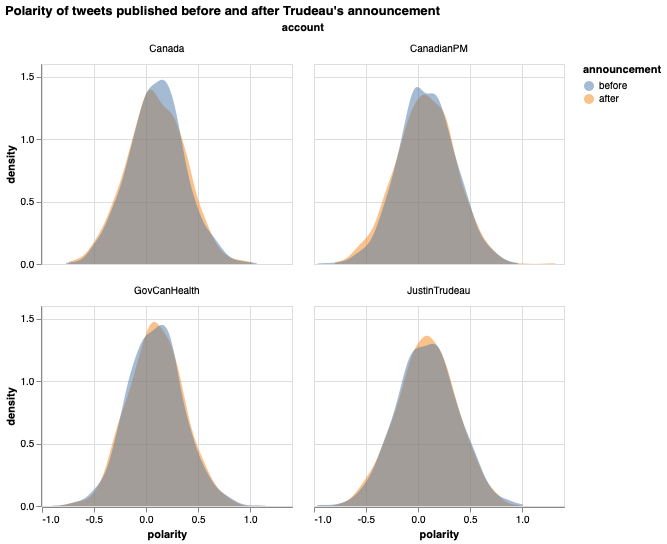

In [41]:
# Select stats for Polarity
df_stats_polar = df_stats[['polarity', 'account', 'announcement']]

# Get samples
my_dict = {}
num = 0
for i in df_stats_polar.account.unique():
    for j in df_stats_polar.announcement.unique():
        my_df = df_stats_polar[(df_stats_polar.account == i) & (df_stats_polar.announcement == j)].polarity[['mean', 'std']]
        mu = float(my_df['mean'])
        sd = float(my_df['std'])
        my_dict[num] = {
            "account": i,
            "announcement": j,
            "mu": mu,
            "sd": sd,
            "samples": np.random.normal(mu, sd, 2_000)
        }
        num += 1

df_polar_samples = pd.DataFrame()
for i in my_dict:
    df_polar_samples = pd.concat([df_polar_samples, pd.DataFrame(my_dict[i])])

df_polar_samples.reset_index(drop=True, inplace=True)

# Plot
alt.Chart(df_polar_samples, width=250, height=200).transform_density(
    'samples',
    groupby=['account', 'announcement'],
    as_=['samples', 'density']
).mark_area(opacity=0.5).encode(
    x=alt.X("samples:Q", title="polarity"),
    y='density:Q',
    color=alt.Color("announcement", sort=['before', 'after'])
).facet(
    "account",
    columns=2
).properties(
    title="Polarity of tweets published before and after Trudeau's announcement"
)

#### Subjectivity

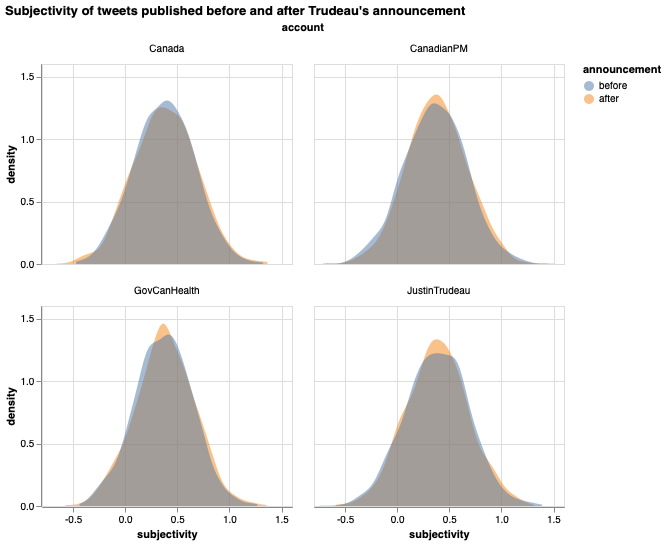

In [40]:
# Select stats for Subjectivity
df_stats_subj = df_stats[['subjectivity', 'account', 'announcement']]

# Get samples
my_dict = {}
num = 0
for i in df_stats_subj.account.unique():
    for j in df_stats_subj.announcement.unique():
        my_df = df_stats_subj[(df_stats_subj.account == i) & (df_stats_subj.announcement == j)].subjectivity[['mean', 'std']]
        mu = float(my_df['mean'])
        sd = float(my_df['std'])
        my_dict[num] = {
            "account": i,
            "announcement": j,
            "mu": mu,
            "sd": sd,
            "samples": np.random.normal(mu, sd, 2_000)
        }
        num += 1

df_subj_samples = pd.DataFrame()
for i in my_dict:
    df_subj_samples = pd.concat([df_subj_samples, pd.DataFrame(my_dict[i])])

df_subj_samples.reset_index(drop=True, inplace=True)

# Plot
alt.Chart(df_subj_samples, width=250, height=200).transform_density(
    'samples',
    groupby=['account', 'announcement'],
    as_=['samples', 'density']
).mark_area(opacity=0.5).encode(
    x=alt.X("samples:Q", title="subjectivity"),
    y='density:Q',
    color=alt.Color("announcement", sort=['before', 'after'])
).facet(
    "account",
    columns=2
).properties(
    title="Subjectivity of tweets published before and after Trudeau's announcement"
)

> When generating samples with the mean and standar deviation of the polarity and subjectivity, it looks that there is not any difference in sentiment of tweets before and after Trudeau's announcement, in any of the governments accounts.
>
> Just to be sure that, we made some hypotesis testing to know if there is some statistical difference in sentiment of tweets before vs after the annoucement.

### Hypothesis testing sentiment on tweets

In the following table we can see the general statistics all tweets, dividing them in two groups: tweets published before Trudeau's annoucement, and tweets after the announcement.
#### Testing polarity

In [25]:
# Stats from the population of tweets
df.groupby(['announcement'])['polarity'].agg([pd.Series.count, np.mean, np.std]).reset_index()

announcement      count      mean       std
0        after  1641754.0  0.093089  0.280038
1       before  1273391.0  0.090264  0.273660

These two groups have more than 1 Million tweets, and in general any statistical test is going to be affected by a sample size this large.

So, in this case, we select a 1,000 sub-sample for each group -tweets before and after the announcement-, and use a t-test to compare the means between the two groups. 

$H_0:$ The mean polarity tweets published after Trudeau's annoucement is the same or lower than the mean polarity of tweets published before the announcement.  
$H_A:$ The mean polarity tweets published after Trudeau's annoucement is higher (with comments more positive) than the mean polarity of tweets published before the announcement.  
  
In other words:  
$H_0: \mu_{~after} \leq \mu_{~before}$  
$H_A: \mu_{~after} > \mu_{~before}$  

In [26]:
# select 1,000 tweets sample for each group, for polarity
np.random.seed(1)
df_polar_before = df[df.announcement == "before"].reset_index()[['polarity']].sample(1_000)
df_polar_after =  df[df.announcement ==  "after"].reset_index()[['polarity']].sample(1_000)

In [27]:
# hypothesis testing
ttest, pval = ttest_ind(df_polar_before, df_polar_after)
print("p-value", pval)

if pval < 0.05:
    print("We reject the null hypothesis")
else:
    print("We can't reject null hypothesis")

p-value [0.05721753]
We can't reject null hypothesis


> With a sub-sample of 1,000 tweets size, we can't reject the null hypothesis: the mean polarity of tweets published after Trudeau's annoucement is the same or lower than the mean polarity of tweets published before the announcement. This result is consistent with the descriptive analysis made in the previous sections.

#### Testing subjectivity

In [28]:
# Stats from the population of tweets
df.groupby(['announcement'])['subjectivity'].agg([pd.Series.count, np.mean, np.std]).reset_index()

announcement      count      mean       std
0        after  1641754.0  0.375612  0.299242
1       before  1273391.0  0.366647  0.295993

Similar to the hypothesis test done for polarity, we select a 1,000 sub-sample for each group -tweets before and after the announcement-, and use a t-test to compare the means between the two groups. 

$H_0:$ The mean subjectivity tweets published after Trudeau's annoucement is the same to the mean subjectivity of tweets published before the announcement.  
$H_A:$ The mean subjectivity tweets published after Trudeau's annoucement is different to the mean subjectivity of tweets published before the announcement.  
  
In other words:  
$H_0: \mu_{~after} = \mu_{~before}$  
$H_A: \mu_{~after} \neq \mu_{~before}$  

In [29]:
# select 1,000 tweets sample for each group, for subjectivity
np.random.seed(1)
df_polar_before = df[df.announcement == "before"].reset_index()[['subjectivity']].sample(1_000)
df_polar_after =  df[df.announcement ==  "after"].reset_index()[['subjectivity']].sample(1_000)

In [30]:
# hypothesis testing
ttest, pval = ttest_ind(df_polar_before, df_polar_after)
print("p-value", pval)

if pval < 0.05:
    print("We reject the null hypothesis")
else:
    print("We can't reject null hypothesis")

p-value [0.10505159]
We can't reject null hypothesis


> Similar to the olarity analysis, with a sub-sample of 1,000 tweets size, we can't reject the null hypothesis: the mean subjectivity tweets published after Trudeau's annoucement is the same to the mean subjectivity of tweets published before the announcement. This result is also consistent with the descriptive analysis made in the previous sections.

## Volume of tweets

### Volume of tweets

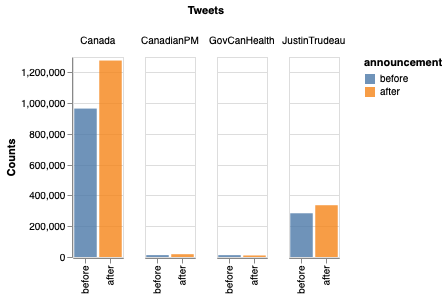

In [42]:
# plot volume of tweets 
df_volume = df.groupby(['account', 'announcement'])['tweet'].agg([pd.Series.count]).reset_index()
alt.Chart(df_volume, width=50, height=200).mark_bar(opacity=0.8).encode(
    x=alt.X('announcement', sort=['before', 'after'], title=""),
    y=alt.Y('count', title="Counts"), #scale=alt.Scale(type='log')), 
    color=alt.Color('announcement', sort=['before', 'after']),
    column=alt.Column('account', title="Tweets")
)

> When comparing the volume of tweets published before and after, we can find that Trudeau's announcement had an impact in the number of tweets of users that mention any of the Canadian Government's account.

### Volume of actions and reactions: Reply, Retweet, Like and Quote

In [43]:
# dataframe with actions
df_volume = pd.DataFrame(df.groupby(['account', 'announcement'])\
                         ['replyCount', 'retweetCount', 'likeCount', 'quoteCount'].sum().stack())\
                         .reset_index().rename(columns = {'level_2':'type',0:'counts'})

In [46]:
def plot_volume(df, my_type='Reply'):
    """
    Funtion that uses altair to plot the volumen of a selected action 
    among: reply, retweet, like and quote.
    
    Parameters
    -------------
    df : (DataFrame)
        dataframe with three columns: twitter account, announcement, and a
        type of action.
    my_type : (str)
        type of action: reply, retweet, like and quote

    Returns
    -------------
    (plot) altair plot

    Example
    -------------
    plot_volume(df_volume, 'Like')
    """
    plot = alt.Chart(df[df.type == (my_type.lower()+"Count")], width=50, height=200).mark_bar(opacity=0.8).encode(
        x=alt.X('announcement', sort=['before', 'after'], title=""),
        y=alt.Y('counts', title="Counts") ,# scale=alt.Scale(type='log')),
        color=alt.Color('announcement', sort=['before', 'after']),
        column=alt.Column('account', title=my_type)
    )
    return plot


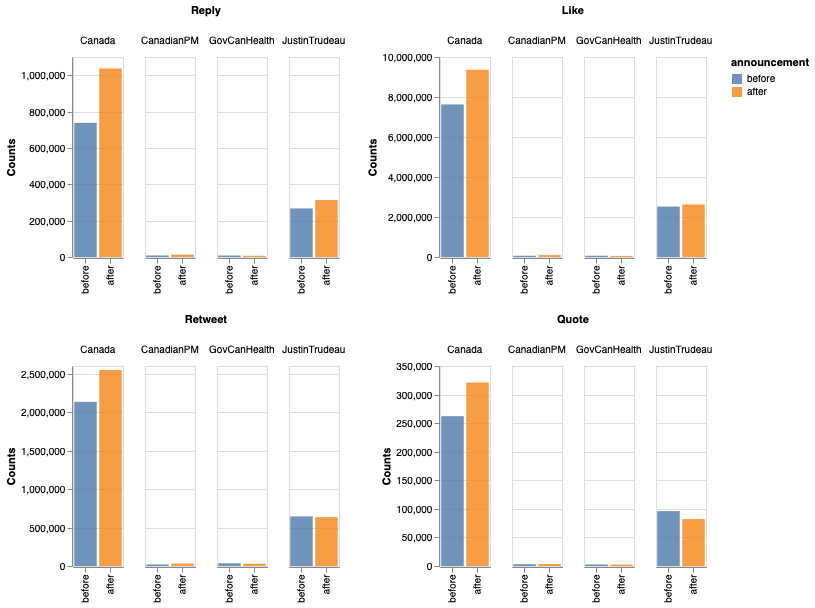

In [47]:
plot_1 = plot_volume(df_volume)
plot_2 = plot_volume(df_volume, 'Retweet')
plot_3 = plot_volume(df_volume, 'Like')
plot_4 = plot_volume(df_volume, 'Quote')

(plot_1 & plot_2) | (plot_3 & plot_4)
# df_volume#['replyCount']

> Also, the annoucement had an impact in the actions and reactions of users, increasing the number of replies, likes, retweets and quotes when comparing this actions before and after the announcement.

## Final comments

The aim of this project was to compare the sentiment analysis of people before and after Trudeau's annoucement on March 27th, 2020, where the Canadian Government was willing to support small businesses and employees after Covid-19 finnancial impact.

To measure this impact we compare the polarity and subjectivity of tweets published before and after the annoucement mentioning Canadian Government's Twitter accounts ([@JustinTrudeau](https://twitter.com/JustinTrudeau?s=20), [@CanadianPM](https://twitter.com/CanadianPM), [@Canada](https://twitter.com/canada?lang=en) and [@GovCanHealth](https://twitter.com/govcanhealth?lang=en)).

While the sentiment analysis didn't show any difference on tweets sent before and after the annoucement, it impact in the volume of tweets, actions and reactions of users as likes, replies, retweets and quotes.
